## Pixel  Classification - Detection of thaw slumps in Banks Island.

We use labels from the multi-band image, which contains the **linear trends** of several environmental indices + SWIR band, and the slope(DEM)+topofrafhic parametres, to train the model(s). The multi-band image covers a part of the Banks Island at the East. Τhe models are trained on the basis of linear trends originating from this small area in the east and the predictions are applied to the whole island.

In [3]:
# import some modules
import numpy as np
import pandas as pd
import rasterio
from rasterio.mask import mask
import geopandas as gpd
from shapely.geometry import mapping
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib as mpl
import os
# utility
from sklearn.preprocessing import StandardScaler, QuantileTransformer, PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score, cross_val_predict,GridSearchCV, StratifiedShuffleSplit, StratifiedKFold
from sklearn.model_selection import train_test_split
# models
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn import svm
from sklearn.linear_model import Perceptron
from sklearn.neural_network import MLPClassifier
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore');
%matplotlib inline
#plt.rcParams["figure.figsize"] = (12, 5)
#mpl.rcParams['figure.dpi']= 300
import rasterio
from sklearn.metrics import plot_confusion_matrix

2022-08-24 22:02:41.067412: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-24 22:02:41.067475: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Prepare the dataset

In [4]:
# Variables for data filepaths

# the multi-band image which contains linear trends (12 bands) and topographic characteristics (8 bands)
multi='East_multi_20b_10m.tif' 
# the labels (rectangulars)
label_fp = '15Χ15m_end_2004_start_2009_4326B_3.shp' 
# variable with band list
band_list = ['TCB','TCG','TCW','NDWI','MNDWI','EVI','NDVI','SAVI','MSAVI','MSI','NDMI','SWIR','Slope','Profile curvature','Tangential curvature',"dx E-W slope", "dy N-S slope","dxx","dyy","dxy"]

In [5]:
# load the Landsat scene and print the metadata
full_dataset = rasterio.open(multi) #
# assign the number of bands to a variable
n_bands = full_dataset.count
n_bands

20

We will apply/test the model and make the predictions on the following 3 images:
<br>full_dataset2, full_dataset3, full_dataset4 
<br>These 3 images correspond to the south, north and central part of the Banks Island.
<br>For the creation of the model we use the following 12 bands out of 20: <br>'TCB','TCG','TCW','NDWI','MNDWI','EVI','NDVI','SAVI','MSAVI','MSI','NDMI','SWIR'

In [ ]:
#Predicted image 
#The island splitted into 3 zones (3 images)
# Read the image for the southern part of the island
full_dataset2 = rasterio.open('multi_32B_South.tif') #
# assign the number of bands to a variable
n_bands2 = full_dataset2.count
#n_bands2

#Read the image for the central part of the Island
full_dataset3 = rasterio.open('Multi_bands_central.tif') #
# assign the number of bands to a variable
n_bands3 = full_dataset3.count
#n_bands3

# Read the image for the northern part of the island
full_dataset4 = rasterio.open('Multi_bands_north.tif') #
# assign the number of bands to a variable
n_bands4 = full_dataset4.count
#n_bands4

In [9]:
print(full_dataset2.meta)

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 21852, 'height': 4205, 'count': 31, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.0002694945852553547, 0.0, -126.010835142,
       0.0, -0.0002694942756242596, 72.20892)}


**Image**

In [10]:
# show the raster
img_all2= full_dataset2.read()
print(img_all2.shape) # (20,4205,21852)

In [ ]:
# show the raster
img_all3= full_dataset3.read()
print(img_all3.shape) #(20, 4024, 34973)

In [ ]:
# show the raster
img_all4= full_dataset4.read()
print(img_all4.shape) # (20, 4756, 35216 )

In [14]:
#load the shapefile
shapefile = gpd.read_file(label_fp)
# print the  projections and the labels
print('\nThere are {} labels for the image'.format(len(shapefile)))
print('the labels are {}'.format(np.unique(shapefile.classname)))
print('The projection is: {}'.format(shapefile.crs))


There are 197 labels for the image
the labels are ['no' 'yes']
The projection is: epsg:4326


In [15]:
# now load the shapefile using geopandas and check it's projection
# shapefile = gpd.read_file(label_fp)

# print the head
print(shapefile.head())
print('\nthere are {} labels'.format(len(shapefile)))
print('\nthe labels are {}'.format(np.unique(shapefile.classname)))
# shapefile = shapefile.to_crs({'init': 'epsg:4326'})
print('\nprojection is: {}'.format(shapefile.crs))

   Longitude  Latitude  Number Type  First year  End date classname  \
0 -120.77874  71.98997  1891.0    S      1999.0    2100.0       yes   
1 -120.55518  71.77429   300.0    R      1999.0    2100.0       yes   
2 -120.44616  71.98908  1959.0    R      1999.0    2100.0       yes   
3 -120.98573  71.68062  1412.0    R      2006.0    2100.0       yes   
4 -120.86970  71.99448  1878.0    L      1999.0    2100.0       yes   

                                            geometry  
0  POLYGON ((-120.77829 71.99010, -120.77832 71.9...  
1  POLYGON ((-120.55473 71.77442, -120.55477 71.7...  
2  POLYGON ((-120.44694 71.98958, -120.44698 71.9...  
3  POLYGON ((-120.98518 71.68104, -120.98521 71.6...  
4  POLYGON ((-120.86967 71.99480, -120.86970 71.9...  

there are 197 labels

the labels are ['no' 'yes']

projection is: epsg:4326


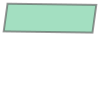

In [16]:
# this generates a list of shapely geometries
geoms = shapefile.geometry.values 
geometry = geoms[79] 
geometry

In [17]:
# transform to GeoJSON format using rasterio 'mapping' function
feature = [mapping(geometry)]

In [18]:
# pixels for training
X = np.array([], dtype=np.float32).reshape(n_bands, -1)
# labels for training
y = np.array([], dtype=np.string_)

In [23]:
# looping over geometries
#we "take" the values from the pixels using the shapefile(labels)
#we use the image "full_dataset" (smaller image from the East part of the Island)

for index, geom in enumerate(geoms):
    # get the current polygon
    feature = [mapping(geom)]
    # get the classname for the polygon
    classname = shapefile['classname'][index]
    # the mask function returns an array of the raster pixels within this polygon and set nodata =10000
    out_image = mask(full_dataset, feature, nodata=10000, crop=True)[0]
#     # eliminate all the pixels with 0 values for all bands - AKA not actually part of the shapefile
    out_image = out_image[:, ~np.all(out_image == 10000 , axis=0)]
#     # append the labels to the y array
    y = np.append(y, [classname] * out_image.shape[1]) 
#     # stack the pixels onto the pixel array
    X = np.hstack((X, out_image))


In [24]:
#X #pixels for training
X.shape

(20, 4015)

In [25]:
#y #labels for training
y.shape

(4015,)

In [26]:
labels = np.unique(shapefile["classname"])
print('The training data include {} classes: {}'.format(labels.size, labels))
# We will need a "X" matrix containing our features, and a "y" array containing our labels
print('Our X matrix is sized: {}'.format(X.shape))
print('Our y array is sized: {}\n'.format(y.shape))

The training data include 2 classes: ['no' 'yes']
Our X matrix is sized: (20, 4015)
Our y array is sized: (4015,)



Masked area shape is: (20, 5, 11)

So this clip (with class no) is a 5 by 11 pixel stack of the 20 groub bands.

And the first band looks like so:


Text(0.5, 1.0, 'TCB')

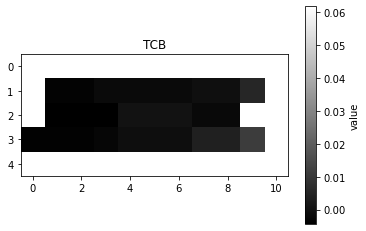

In [27]:
# transform to GeoJSON format using rasterio 'mapping' function
feature = [mapping(geometry)]

# and finaly pull out the the pixel values with mask
out_image = mask(full_dataset, feature, crop=True, filled=True)[0]
print('Masked area shape is: {}'.format(out_image.shape))

print('\nSo this clip (with class {}) is a {} by {} pixel stack of the {} groub bands.'
      .format(classname, out_image.shape[1], out_image.shape[2], out_image.shape[0]))

print('\nAnd the first band looks like so:')

fig, ax = plt.subplots(1,1)
im = ax.imshow(out_image[0], cmap='gray')
fig.colorbar(im, ax=ax, label='value')
ax.set_title('{}'.format(band_list[0]))

In [28]:
# first reshape the X array for passing to classifiers
X_reshape = X.T      # 

print(X.shape, X_reshape.shape)

(20, 4015) (4015, 20)


In [29]:
# now save out the pixel values
with open('multi_pixel_bands.npy', 'wb') as f:
    np.save(f, X_reshape)

# and save the associated class of each pixel
with open('multi_pixel_band_classes.npy', 'wb') as f:
    np.save(f, y)

In [30]:
#East part
# save width and height for later reshaping
width = full_dataset.meta['width'] 
height = full_dataset.meta['height']

In [31]:
#for the South
width2 = full_dataset2.meta['width'] 
height2 = full_dataset2.meta['height']

In [32]:
#for the Central
width3 = full_dataset3.meta['width'] 
height3 = full_dataset3.meta['height']

In [33]:
#for the North
width4 = full_dataset4.meta['width'] 
height4 = full_dataset4.meta['height']

In [39]:
# load training data 
X = np.load('multi_pixel_bands.npy')
y = np.load('multi_pixel_band_classes.npy')

# load predected image (small area East)
X_pred = full_dataset.read()
# adjust the axis to move band axis to the last dimension
X_pred = np.moveaxis(X_pred, 0, -1)
# finally reshape to create array of pixels and values
X_pred = X_pred.reshape(-1, full_dataset.meta['count'])

print(X_pred.shape)

(8669676, 20)


In [40]:
# load predicted image (South)
X_pred2 = full_dataset2.read()
# adjust the axis to move band axis to the last dimension
X_pred2 = np.moveaxis(X_pred2, 0, -1)
# finally reshape to create array of pixels and values
X_pred2 = X_pred2.reshape(-1, full_dataset2.meta['count'])

print(X_pred2.shape)

(91887660, 31)


In [41]:
# load predicted image (Central)
X_pred3 = full_dataset3.read()
# adjust the axis to move band axis to the last dimension
X_pred3 = np.moveaxis(X_pred3, 0, -1)
# finally reshape to create array of pixels and values
X_pred3 = X_pred3.reshape(-1, full_dataset3.meta['count'])

print(X_pred3.shape)

(140731352, 13)


In [42]:
# load predicted image (North)
X_pred4 = full_dataset4.read()
# adjust the axis to move band axis to the last dimension
X_pred4 = np.moveaxis(X_pred4, 0, -1)
# finally reshape to create array of pixels and values
X_pred4 = X_pred4.reshape(-1, full_dataset4.meta['count'])

print(X_pred4.shape)

(167487296, 13)


In [43]:
#We choose which bands to use for training (from the small area at the East)
reduce_bands = True
# reduce bands
if reduce_bands:
    X = X[:, [0,1,2,3,4,5,6,7,8,9,10,11]]
    X_pred = X_pred[:, [0,1,2,3,4,5,6,7,8,9,10,11]]

In [44]:
print(X_pred.shape)

(8669676, 12)


In [45]:
#predicted image (South)
X_pred2 = X_pred2[:, [0,1,2,3,4,5,6,7,8,9,10,11]]

In [46]:
#predicted image (Central)
X_pred3 = X_pred3[:, [0,1,2,3,4,5,6,7,8,9,10,11]]

In [47]:
#predicted image (North)
X_pred4 = X_pred4[:, [0,1,2,3,4,5,6,7,8,9,10,11]]

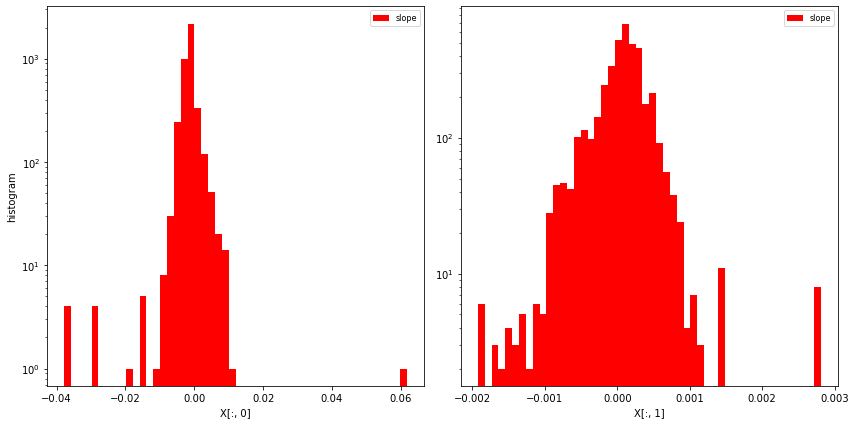

In [51]:
# plot density of data point for each dimension to see if there are outliers
if reduce_bands:
    fig, axs = plt.subplots(1, 2, figsize=(12,6))
else:
    fig, axs = plt.subplots(2, 5)
axs = axs.flatten()


colors = ['red']
axs[0].set_ylabel('histogram')


for i, ax in enumerate(axs):
    ax.hist(X[:, i], bins=50,color=colors, label="slope" )
    ax.set_xlabel('X[:, {}]'.format(i))
    ax.set_yscale('log')
    ax.legend(prop={'size': 8})
fig.tight_layout()


In [52]:
# parameters
# shuffle X, y
rp = np.random.permutation(len(X))
X = X[rp]
y = y[rp]

print(X.shape, X_pred.shape, y.shape)

(4015, 12) (8669676, 12) (4015,)


In [53]:
print(X.dtype, X_pred.dtype, y.dtype)

float32 float32 <U3


In [54]:
# print(X.mean(axis=0))
# print(X.std(axis=0))

In [55]:
# show label counts
df = pd.DataFrame(X)
df['label'] = y
print("The labels for the 12-band image \n", df.label.value_counts())

The labels for the 13-band image 
 no     3505
yes     510
Name: label, dtype: int64


In [56]:
# reclassify the string label names as numeric values
labels = ['no', 'yes']

for i, label in enumerate(labels):
    y[y == label] = i
y= y.astype(int)

In [57]:
# Convert to numpy arrays

# features = np.array(features)
# labels = np.array(labels)

# Training

In [ ]:
# Training and Testing Sets
from sklearn.model_selection import train_test_split
#split the data (65-35)
X_train, X_test, train_labels, test_labels = train_test_split(X, y, test_size = 0.35, random_state = 42)

In [90]:
# define function to validate models
def evaluate_model(clf,cv):
    # train model
    clf.fit(X_train, train_labels)        
    # compute cross-validation score
    scores = cross_val_score(clf, X_train, train_labels, cv=cv)
    # compute mean score and 95% confidence interval of the score estimate
    print("Accuracy : %0.4f (+/- %0.4f)" % (scores.mean(), scores.std() * 2))
    # return to keep track
    return clf, scores.mean(), scores.std()*2    

# keep track of scores for different models

names = []      
clfs = []
scores = []
scores_std = []
f1=[]

**1. KNN_QT_uniform**

In [91]:
clf = make_pipeline(
    QuantileTransformer(n_quantiles=50, output_distribution='uniform'), 
    KNeighborsClassifier()
)
# classifier
param_grid={'kneighborsclassifier__weights':['uniform', 'distance'] ,'kneighborsclassifier__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}
clf1 = GridSearchCV(estimator=clf, param_grid=param_grid, cv=15, refit=True,verbose=0)   

# evaluate
cv = StratifiedKFold(n_splits=15)
# cv = StratifiedShuffleSplit(n_splits=50)
clf1, score, score_std = evaluate_model(clf1, cv)

# keep track of resultsy_predicted = cross_val_predict(gs_clf.best_estimator_, X, y)
names.append('KNN_QT_uniform')
clfs.append(clf1)
scores.append(score)
scores_std.append(score_std)

Accuracy : 0.9885 (+/- 0.0103)


In [92]:
# save results
cv_results = pd.DataFrame(clf1.cv_results_)      
#cv_results

In [93]:
clf1.score(X_test,test_labels)

0.9928876244665719

In [94]:
y_predicted1 = cross_val_predict(clf1, X_test, test_labels)

In [95]:
from sklearn.metrics import f1_score
f1_score(test_labels,y_predicted1, average='binary')

0.9459459459459459

Passing these predictions into an evaluation metric may not be a valid way to measure generalization performance. Results can differ from cross_validate and cross_val_score unless all tests sets have equal size and the metric decomposes over samples.

In [96]:
from sklearn import metrics
print(metrics.classification_report(test_labels, y_predicted1, digits=4))

              precision    recall  f1-score   support

           0     0.9910    0.9926    0.9918      1220
           1     0.9511    0.9409    0.9459       186

    accuracy                         0.9858      1406
   macro avg     0.9710    0.9667    0.9689      1406
weighted avg     0.9857    0.9858    0.9857      1406



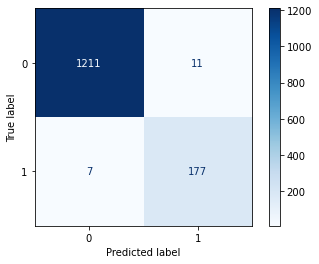

In [97]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(clf1, X_test, y_predicted1,
                                 #display_labels=classnames,
                                 cmap=plt.cm.Blues)

In [98]:
import copy
from sklearn.metrics import f1_score 
y_pred_KNN=copy.deepcopy(y_predicted1)

y_int=copy.deepcopy(test_labels)

# reclassify the string label names as numeric values
labels = ['no', 'yes']

for i, label in enumerate(labels):
    y_int[y_int == label] = i
    y_pred_KNN[y_pred_KNN == label] = i
y_int= y_int.astype(int)
y_pred_KNN= y_pred_KNN.astype(int)

f1_score(y_int, y_pred_KNN)  

f1.append(f1_score(y_int, y_pred_KNN))


In [100]:
from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(test_labels, y_predicted1).ravel()

false_positive_rate = fp / (fp + tn)
print("The false_positive_rate is:",false_positive_rate)

false_negative_rate = fn / (tp + fn)
print("The false_negative_rate is:",false_negative_rate)

true_negative_rate = tn / (tn + fp)
print("The true_negative_rate is:",true_negative_rate)

negative_predictive_value = tn/ (tn + fn)
print("The negative_predictive_value is:",negative_predictive_value)

false_discovery_rate = fp/ (tp + fp)
print("The false_discovery_rate is:",false_discovery_rate)

true_positive_rate = tp / (tp + fn)
print("The true_positive_rate is:",true_positive_rate)
# or simply
#recall_score(y_true, y_pred_class)

positive_predictive_value = tp/ (tp + fp)
print("The positive_predictive_value is:",positive_predictive_value)

The false_positive_rate is: 0.007377049180327869
The false_negative_rate is: 0.05913978494623656
The true_negative_rate is: 0.9926229508196721
The negative_predictive_value is: 0.9909983633387889
The false_discovery_rate is: 0.04891304347826087
The true_positive_rate is: 0.9408602150537635
The positive_predictive_value is: 0.9510869565217391


In [101]:
from sklearn.inspection import permutation_importance
from matplotlib import pyplot


# perform permutation importance
results1 = permutation_importance(clf1, X_test, test_labels, scoring='accuracy')
# get importance
importances1 = results1.importances_mean
# summarize feature importance
# for i,v in enumerate(importances):
#     print('Feature: %0d, Score: %.5f' % (i,v))
# # plot feature importance
# pyplot.bar([x for x in range(len(importances))], importances)
# pyplot.show()

In [102]:
feature_list =  ['TCB','TCG','TCW','NDWI','MNDWI','EVI','NDVI','SAVI','MSAVI','MSI','NDMI','SWIR']


# List of tuples with variable and importance
feature_importances1 = [(feature, round(importance1, 2)) for feature, importance1 in zip(feature_list, importances1)]

# Sort the feature importances by most important first
feature_importances1 = sorted(feature_importances1, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances1];

Variable: TCW                  Importance: 0.04
Variable: EVI                  Importance: 0.04
Variable: TCG                  Importance: 0.03
Variable: MNDWI                Importance: 0.03
Variable: NDVI                 Importance: 0.03
Variable: SAVI                 Importance: 0.03
Variable: MSAVI                Importance: 0.03
Variable: MSI                  Importance: 0.03
Variable: SWIR                 Importance: 0.03
Variable: TCB                  Importance: 0.02
Variable: NDWI                 Importance: 0.02
Variable: NDMI                 Importance: 0.02


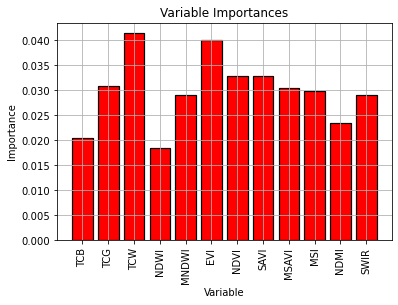

In [104]:
# Reset style 
#plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(importances1)))

# Make a bar chart
plt.bar(x_values, importances1, orientation = 'vertical', color = 'r', edgecolor = 'k', linewidth = 1.2)

# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')

# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');
plt.grid()

**2.Random Forest**

In [120]:
# First create the base model to tune

import copy
from sklearn.metrics import f1_score 
param_grid={'randomforestclassifier__n_estimators': [100]}
clf = make_pipeline(
    QuantileTransformer(n_quantiles=50, output_distribution='uniform'), RandomForestClassifier())

clf3 = GridSearchCV(estimator=clf,param_grid=param_grid,cv=15, refit=True,verbose=0)
    
cv = StratifiedKFold(n_splits=15)

# evaluate
clf3, score, score_std = evaluate_model(clf3, cv)

# keep track of results y_predicted = cross_val_predict(gs_clf.best_estimator_, X, y)

names.append('RF_100_trees_uni')
clfs.append(clf3)
scores.append(score)
scores_std.append(score_std)

Accuracy : 0.9885 (+/- 0.0119)


In [121]:
# save results
cv_results = pd.DataFrame(clf3.cv_results_)      
#cv_results

In [122]:
clf3.score(X_test,test_labels)

0.9928876244665719

In [123]:
y_predicted3 = cross_val_predict(clf3, X_test, test_labels)

In [124]:
from sklearn.metrics import f1_score
f1_score(test_labels,y_predicted3, average='binary')

0.9456521739130435

In [125]:
from sklearn import metrics
print(metrics.classification_report(test_labels, y_predicted3, digits=4))

              precision    recall  f1-score   support

           0     0.9902    0.9934    0.9918      1220
           1     0.9560    0.9355    0.9457       186

    accuracy                         0.9858      1406
   macro avg     0.9731    0.9645    0.9687      1406
weighted avg     0.9857    0.9858    0.9857      1406



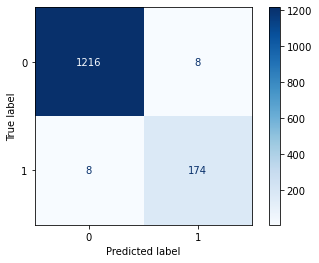

In [126]:
plot_confusion_matrix(clf3, X_test, y_predicted3,
                                 #display_labels=classnames,
                                 cmap=plt.cm.Blues)

In [127]:
import copy
from sklearn.metrics import f1_score 
y_pred_RF=copy.deepcopy(y_predicted3)

y_int=copy.deepcopy(test_labels)

# reclassify the string label names as numeric values
labels = ['no', 'yes']

for i, label in enumerate(labels):
    y_int[y_int == label] = i
    y_pred_RF[y_pred_RF == label] = i
y_int= y_int.astype(int)
y_pred_RF= y_pred_RF.astype(int)

f1_score(y_int, y_pred_RF)  

f1.append(f1_score(y_int, y_pred_RF))

In [129]:
## from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(test_labels, y_predicted3).ravel()

false_positive_rate = fp / (fp + tn)
print("The false_positive_rate is:",false_positive_rate)

false_negative_rate = fn / (tp + fn)
print("The false_negative_rate is:",false_negative_rate)

true_negative_rate = tn / (tn + fp)
print("The true_negative_rate is:",true_negative_rate)

negative_predictive_value = tn/ (tn + fn)
print("The negative_predictive_value is:",negative_predictive_value)

false_discovery_rate = fp/ (tp + fp)
print("The false_discovery_rate is:",false_discovery_rate)

true_positive_rate = tp / (tp + fn)
print("The true_positive_rate is:",true_positive_rate)
# or simply
#recall_score(y_true, y_pred_class)

positive_predictive_value = tp/ (tp + fp)
print("The positive_predictive_value is:",positive_predictive_value)

The false_positive_rate is: 0.006557377049180328
The false_negative_rate is: 0.06451612903225806
The true_negative_rate is: 0.9934426229508196
The negative_predictive_value is: 0.9901960784313726
The false_discovery_rate is: 0.04395604395604396
The true_positive_rate is: 0.9354838709677419
The positive_predictive_value is: 0.9560439560439561


In [130]:
from sklearn.inspection import permutation_importance
from matplotlib import pyplot


# perform permutation importance
results3 = permutation_importance(clf3, X_test, test_labels, scoring='accuracy')
# get importance
importances3 = results3.importances_mean

In [131]:
feature_list =  ['TCB','TCG','TCW','NDWI','MNDWI','EVI','NDVI','SAVI','MSAVI','MSI','NDMI','SWIR']


# List of tuples with variable and importance
feature_importances3 = [(feature, round(importance3, 2)) for feature, importance3 in zip(feature_list, importances3)]

# Sort the feature importances by most important first
feature_importances3 = sorted(feature_importances3, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances3];

Variable: TCW                  Importance: 0.01
Variable: SAVI                 Importance: 0.01
Variable: SWIR                 Importance: 0.01
Variable: TCB                  Importance: 0.0
Variable: TCG                  Importance: 0.0
Variable: NDWI                 Importance: 0.0
Variable: MNDWI                Importance: 0.0
Variable: EVI                  Importance: 0.0
Variable: NDVI                 Importance: 0.0
Variable: MSAVI                Importance: 0.0
Variable: MSI                  Importance: 0.0
Variable: NDMI                 Importance: 0.0


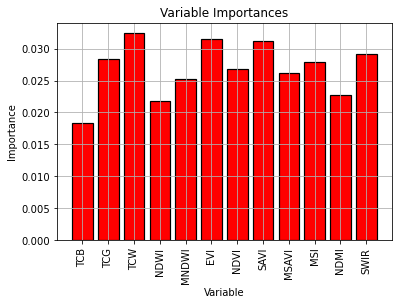

In [132]:
# Reset style 
#plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(importances3)))

# Make a bar chart
plt.bar(x_values, importances1, orientation = 'vertical', color = 'r', edgecolor = 'k', linewidth = 1.2)

# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')

# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');
plt.grid()

## Tuning models based f1

**Tunning KNN based on fi score**

In [143]:
param_grid = {
    'kneighborsclassifier__n_neighbors': [1,2,3,4,5,6,7,8,9,10,11,12, 13,14, 15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30],
}
clf = make_pipeline(
    QuantileTransformer(n_quantiles=50, output_distribution='uniform'), KNeighborsClassifier())
# Create the grid search model and fit to the training data
neighbors_grid_search_all = GridSearchCV(estimator =clf, param_grid=param_grid,return_train_score=True,refit=True, verbose = 1, n_jobs=-1, cv = 10,
                                scoring = 'f1')
neighbors_grid_search_all.fit(X_train, train_labels);

Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   11.1s finished


In [144]:
train_scores_all=neighbors_grid_search_all.cv_results_['mean_train_score']
#train_scores
test_scores_all=neighbors_grid_search_all.cv_results_['mean_test_score']
#test_scores

In [145]:
import operator
enumerate_object = enumerate(test_scores_all)
sorted_pairs = sorted(enumerate_object, key=operator.itemgetter(1))

sorted_indices = []
for index, element in sorted_pairs:
    sorted_indices.append(index)
print(sorted_indices)

[29, 27, 25, 23, 28, 26, 24, 21, 22, 19, 20, 13, 15, 14, 18, 17, 16, 9, 11, 7, 12, 8, 6, 10, 5, 3, 4, 2, 1, 0]


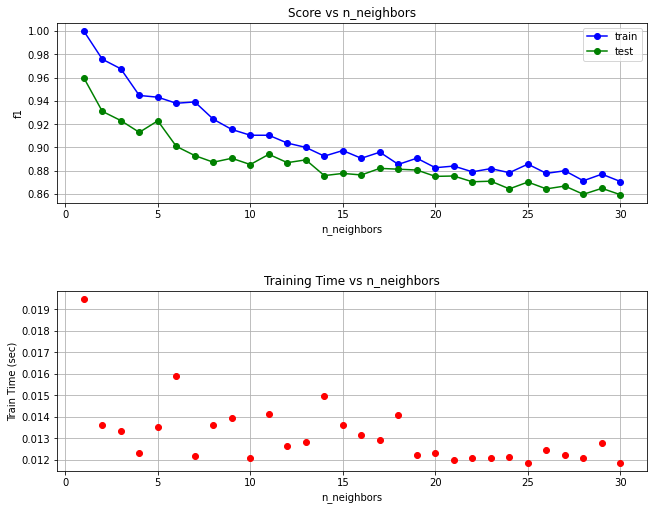

In [146]:
def plot_results(model, param = 'kneighborsclassifier__n_neighbors', name = 'n_neighbors'):
    param_name = 'param_%s' % param

    # Extract information from the cross validation model
    train_scores = model.cv_results_['mean_train_score']
    test_scores = model.cv_results_['mean_test_score']
    train_time = model.cv_results_['mean_fit_time']
    param_values = list(model.cv_results_[param_name])
    
    # Plot the scores over the parameter
    plt.subplots(2, 1, figsize=(10, 8))
    plt.subplot(211)
    plt.plot(param_values, train_scores, 'bo-', label = 'train')
    plt.plot(param_values, test_scores, 'go-', label = 'test')
    #plt.ylim(ymin = -10, ymax = 0)
    plt.legend()
    plt.xlabel(name)
    plt.ylabel('f1')
    plt.title('Score vs %s' % name)
    
    plt.grid()
    plt.tight_layout(pad = 4)

    plt.subplot(212)
    plt.plot(param_values, train_time, 'ro')
    #plt.ylim(ymin = 0.0, ymax = 2.0)
    plt.xlabel(name)
    plt.ylabel('Train Time (sec)')
    plt.title('Training Time vs %s' % name)

    plt.grid()
    plt.tight_layout(pad = 4)
    

plot_results(neighbors_grid_search_all)

In [147]:
clf_c = make_pipeline(
    QuantileTransformer(n_quantiles=50, output_distribution='uniform'), KNeighborsClassifier())
param_grid = {
    'kneighborsclassifier__n_neighbors': [ 8, 7, 6, 3, 5, 4, 2, 1, 0]}
# Create the grid search model and fit to the training data
knn_model_tr_un_f1 = GridSearchCV(estimator =clf_c, param_grid=param_grid,return_train_score=True,refit=True, verbose = 1, n_jobs=-1, cv = 15,)

# evaluate
cv = StratifiedShuffleSplit(n_splits=15)
knn_model_tr_un_f1, score, score_std = evaluate_model(knn_model_tr_un_f1, cv)

# keep track of results
names.append('knn_model_tr_un_f1')
clfs.append(knn_model_tr_un_f1)
scores.append(score)
scores_std.append(score_std)

Fitting 15 folds for each of 9 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed:    3.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 15 folds for each of 9 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed:    2.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 15 folds for each of 9 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 120 out of 135 | elapsed:    2.6s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed:    2.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 15 folds for each of 9 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed:    2.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 15 folds for each of 9 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed:    2.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 15 folds for each of 9 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 120 out of 135 | elapsed:    2.5s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed:    2.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 15 folds for each of 9 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 120 out of 135 | elapsed:    2.7s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed:    2.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 15 folds for each of 9 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed:    2.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 15 folds for each of 9 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed:    2.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 15 folds for each of 9 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 120 out of 135 | elapsed:    2.6s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed:    2.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 15 folds for each of 9 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed:    2.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 15 folds for each of 9 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 120 out of 135 | elapsed:    2.7s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed:    2.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 15 folds for each of 9 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed:    2.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 15 folds for each of 9 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed:    2.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 15 folds for each of 9 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 120 out of 135 | elapsed:    2.7s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed:    2.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 15 folds for each of 9 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.5s


Accuracy : 0.9877 (+/- 0.0080)


[Parallel(n_jobs=-1)]: Done 120 out of 135 | elapsed:    2.8s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed:    2.9s finished


In [148]:
knn_model_tr_un_f1.best_estimator_

Pipeline(steps=[('quantiletransformer', QuantileTransformer(n_quantiles=50)),
                ('kneighborsclassifier', KNeighborsClassifier(n_neighbors=1))])

In [149]:
knn_model_tr_un_f1.score(X_test,test_labels)

0.9928876244665719

In [150]:
# save results
cv_results = pd.DataFrame(knn_model_tr_un_f1.cv_results_)      
#cv_results

In [151]:
y_predicted5= cross_val_predict(knn_model_tr_un_f1, X_test, test_labels)

Fitting 15 folds for each of 9 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed:    1.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 15 folds for each of 9 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 120 out of 135 | elapsed:    1.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed:    1.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 15 folds for each of 9 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed:    1.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 15 folds for each of 9 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed:    1.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 15 folds for each of 9 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed:    1.5s finished


In [152]:
from sklearn import metrics
print(metrics.classification_report(test_labels, y_predicted5, digits=4))

              precision    recall  f1-score   support

           0     0.9926    0.9934    0.9930      1220
           1     0.9568    0.9516    0.9542       186

    accuracy                         0.9879      1406
   macro avg     0.9747    0.9725    0.9736      1406
weighted avg     0.9879    0.9879    0.9879      1406



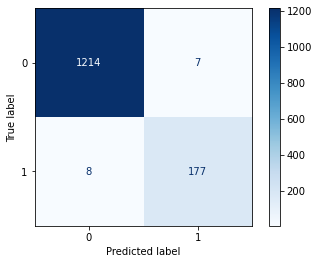

In [153]:
plot_confusion_matrix(knn_model_tr_un_f1, X_test, y_predicted5,
                                 #display_labels=classnames,
                                 cmap=plt.cm.Blues)

In [154]:
from sklearn.metrics import f1_score
f1_score(test_labels,y_predicted5, average='binary')

0.9541778975741241

In [155]:
import copy
from sklearn.metrics import f1_score 
y_pred_KNN=copy.deepcopy(y_predicted5)

y_int=copy.deepcopy(test_labels)

# reclassify the string label names as numeric values
labels = ['no', 'yes']

for i, label in enumerate(labels):
    y_int[y_int == label] = i
    y_pred_KNN[y_pred_KNN == label] = i
y_int= y_int.astype(int)
y_pred_KNN= y_pred_KNN.astype(int)

f1_score(y_int, y_pred_KNN)  

f1.append(f1_score(y_int, y_pred_KNN))

In [157]:
from sklearn.inspection import permutation_importance
from matplotlib import pyplot

# perform permutation importance
results = permutation_importance(knn_model_tr_un_f1, X_test, test_labels, scoring='f1')
# get importance
importances = results.importances_mean
# # summarize feature importance
# for i,v in enumerate(importances):
#     print('Feature: %0d, Score: %.5f' % (i,v))
# # plot feature importance
# pyplot.bar([x for x in range(len(importances))], importances)
# pyplot.show()

In [158]:
feature_list =  ['TCB','TCG','TCW','NDWI','MNDWI','EVI','NDVI','SAVI','MSAVI','MSI','NDMI','SWIR']

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: TCW                  Importance: 0.17
Variable: TCG                  Importance: 0.15
Variable: EVI                  Importance: 0.13
Variable: NDVI                 Importance: 0.12
Variable: MSI                  Importance: 0.12
Variable: SWIR                 Importance: 0.12
Variable: MSAVI                Importance: 0.11
Variable: SAVI                 Importance: 0.1
Variable: TCB                  Importance: 0.09
Variable: MNDWI                Importance: 0.09
Variable: NDWI                 Importance: 0.08
Variable: NDMI                 Importance: 0.08


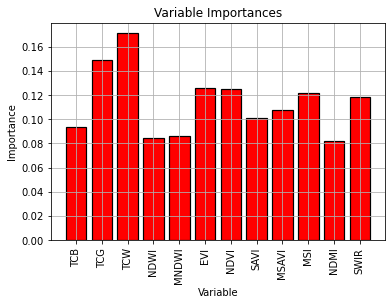

In [159]:
# Reset style 
#plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(importances)))

# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical', color = 'r', edgecolor = 'k', linewidth = 1.2)

# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')

# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');
plt.grid()

**Tunning the RF based f1 score**

In [177]:
param_grid = {
    'randomforestclassifier__n_estimators': [int(x) for x in np.linspace(1, 301, 300)],
#     'bootstrap': [True],
#     'max_depth': [100, None],
#     'max_features': [3],
#     'min_samples_leaf': [ 3],
#     'min_samples_split': [2],
}
clf = make_pipeline(
    QuantileTransformer(n_quantiles=50, output_distribution='uniform'), RandomForestClassifier())
# Create the grid search model and fit to the training data
tree_grid_search_all = GridSearchCV(estimator =clf, param_grid=param_grid,return_train_score=True,refit=True, verbose = 1, n_jobs=-1, cv = 15,
                                scoring = 'f1')
tree_grid_search_all.fit(X_train, train_labels);

Fitting 15 folds for each of 300 candidates, totalling 4500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 416 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done 666 tasks      | elapsed:   28.3s
[Parallel(n_jobs=-1)]: Done 1016 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 1466 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 2016 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 2666 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 3416 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done 4266 tasks      | elapsed: 10.4min
[Parallel(n_jobs=-1)]: Done 4500 out of 4500 | elapsed: 11.2min finished


In [178]:
train_scores_all=tree_grid_search_all.cv_results_['mean_train_score']
#train_scores
test_scores_all=tree_grid_search_all.cv_results_['mean_test_score']
#test_scores

In [179]:
import operator
enumerate_object = enumerate(test_scores_all)
sorted_pairs = sorted(enumerate_object, key=operator.itemgetter(1))

sorted_indices = []
for index, element in sorted_pairs:
    sorted_indices.append(index)
print(sorted_indices)

[0, 1, 2, 3, 13, 4, 7, 10, 60, 26, 20, 5, 80, 107, 41, 47, 36, 173, 31, 21, 19, 69, 65, 85, 38, 268, 89, 101, 159, 287, 56, 111, 261, 45, 71, 192, 235, 242, 40, 22, 9, 14, 39, 143, 49, 34, 73, 109, 128, 97, 32, 24, 61, 201, 67, 189, 208, 37, 108, 142, 244, 113, 151, 165, 179, 182, 17, 131, 262, 92, 12, 54, 48, 43, 62, 74, 77, 94, 104, 124, 132, 135, 148, 160, 163, 164, 171, 172, 175, 178, 194, 218, 224, 226, 228, 233, 237, 240, 245, 248, 255, 257, 263, 264, 272, 274, 276, 278, 285, 291, 294, 297, 58, 68, 130, 199, 258, 266, 293, 112, 116, 185, 207, 18, 11, 6, 115, 72, 50, 114, 76, 55, 144, 25, 78, 79, 90, 247, 82, 87, 102, 117, 119, 121, 123, 134, 136, 147, 150, 152, 154, 162, 168, 169, 176, 180, 196, 197, 213, 217, 220, 225, 230, 236, 238, 239, 249, 250, 253, 256, 260, 269, 275, 279, 289, 290, 295, 28, 98, 138, 149, 202, 215, 216, 259, 270, 271, 277, 282, 288, 292, 81, 166, 177, 51, 241, 246, 296, 52, 29, 105, 8, 122, 137, 190, 195, 211, 214, 234, 15, 35, 153, 57, 66, 100, 126, 127, 1

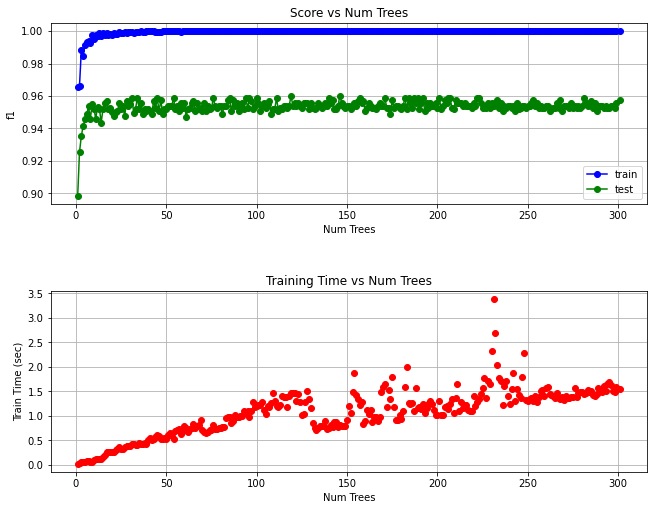

In [180]:
def plot_results(model, param = 'randomforestclassifier__n_estimators', name = 'Num Trees'):
    param_name = 'param_%s' % param

    # Extract information from the cross validation model
    train_scores = model.cv_results_['mean_train_score']
    test_scores = model.cv_results_['mean_test_score']
    train_time = model.cv_results_['mean_fit_time']
    param_values = list(model.cv_results_[param_name])
    
    # Plot the scores over the parameter
    plt.subplots(2, 1, figsize=(10, 8))
    plt.subplot(211)
    plt.plot(param_values, train_scores, 'bo-', label = 'train')
    plt.plot(param_values, test_scores, 'go-', label = 'test')
    #plt.ylim(ymin = -10, ymax = 0)
    plt.legend()
    plt.xlabel(name)
    plt.ylabel('f1')
    plt.title('Score vs %s' % name)
    
    plt.grid()
    plt.tight_layout(pad = 4)

    plt.subplot(212)
    plt.plot(param_values, train_time, 'ro')
    #plt.ylim(ymin = 0.0, ymax = 2.0)
    plt.xlabel(name)
    plt.ylabel('Train Time (sec)')
    plt.title('Training Time vs %s' % name)

    plt.grid()
    plt.tight_layout(pad = 4)
    

plot_results(tree_grid_search_all)

In [181]:
%%time
clf_c = make_pipeline(
    QuantileTransformer(n_quantiles=50, output_distribution='uniform'), RandomForestClassifier())
param_grid={'randomforestclassifier__criterion':['entropy'],
           'randomforestclassifier__n_estimators': [ 99, 139, 181, 183, 186, 205, 206, 221, 222, 118, 145 ]}
RF_model_tr_un_f1 = GridSearchCV(estimator=clf_c, param_grid=param_grid, cv=15,verbose=1, refit=True,return_train_score=True)   

# evaluate
cv = StratifiedShuffleSplit(n_splits=15)
RF_model_tr_un, score, score_std = evaluate_model(RF_model_tr_un_f1, cv)


# keep track of results
names.append('RF_model_tr_un_f1')
clfs.append(RF_model_tr_un)
scores.append(score)
scores_std.append(score_std)

Fitting 15 folds for each of 11 candidates, totalling 165 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 165 out of 165 | elapsed:  1.7min finished


Fitting 15 folds for each of 11 candidates, totalling 165 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 165 out of 165 | elapsed:  1.7min finished


Fitting 15 folds for each of 11 candidates, totalling 165 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 165 out of 165 | elapsed:  1.7min finished


Fitting 15 folds for each of 11 candidates, totalling 165 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 165 out of 165 | elapsed:  1.7min finished


Fitting 15 folds for each of 11 candidates, totalling 165 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 165 out of 165 | elapsed:  1.8min finished


Fitting 15 folds for each of 11 candidates, totalling 165 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 165 out of 165 | elapsed:  1.7min finished


Fitting 15 folds for each of 11 candidates, totalling 165 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 165 out of 165 | elapsed:  1.6min finished


Fitting 15 folds for each of 11 candidates, totalling 165 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 165 out of 165 | elapsed:  1.7min finished


Fitting 15 folds for each of 11 candidates, totalling 165 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 165 out of 165 | elapsed:  1.7min finished


Fitting 15 folds for each of 11 candidates, totalling 165 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 165 out of 165 | elapsed:  1.6min finished


Fitting 15 folds for each of 11 candidates, totalling 165 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 165 out of 165 | elapsed:  1.6min finished


Fitting 15 folds for each of 11 candidates, totalling 165 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 165 out of 165 | elapsed:  1.6min finished


Fitting 15 folds for each of 11 candidates, totalling 165 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 165 out of 165 | elapsed:  1.6min finished


Fitting 15 folds for each of 11 candidates, totalling 165 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 165 out of 165 | elapsed:  1.7min finished


Fitting 15 folds for each of 11 candidates, totalling 165 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 165 out of 165 | elapsed:  1.7min finished


Fitting 15 folds for each of 11 candidates, totalling 165 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 165 out of 165 | elapsed:  1.7min finished


Accuracy : 0.9890 (+/- 0.0111)
CPU times: user 26min 14s, sys: 15.2 s, total: 26min 30s
Wall time: 26min 53s


In [182]:
RF_model_tr_un_f1.best_estimator_

Pipeline(steps=[('quantiletransformer', QuantileTransformer(n_quantiles=50)),
                ('randomforestclassifier',
                 RandomForestClassifier(criterion='entropy',
                                        n_estimators=181))])

In [183]:
RF_model_tr_un_f1.score(X_test,test_labels)

0.9950213371266002

In [184]:
# save results
cv_results = pd.DataFrame(RF_model_tr_un_f1.cv_results_)      
#cv_results

In [185]:
y_predicted7 = cross_val_predict(RF_model_tr_un_f1, X_test, test_labels)

Fitting 15 folds for each of 11 candidates, totalling 165 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 165 out of 165 | elapsed:  1.1min finished


Fitting 15 folds for each of 11 candidates, totalling 165 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 165 out of 165 | elapsed:  1.1min finished


Fitting 15 folds for each of 11 candidates, totalling 165 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 165 out of 165 | elapsed:  1.1min finished


Fitting 15 folds for each of 11 candidates, totalling 165 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 165 out of 165 | elapsed:  1.1min finished


Fitting 15 folds for each of 11 candidates, totalling 165 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 165 out of 165 | elapsed:  1.1min finished


In [186]:
from sklearn import metrics
print(metrics.classification_report(test_labels, y_predicted7, digits=4))

              precision    recall  f1-score   support

           0     0.9902    0.9951    0.9926      1220
           1     0.9667    0.9355    0.9508       186

    accuracy                         0.9872      1406
   macro avg     0.9784    0.9653    0.9717      1406
weighted avg     0.9871    0.9872    0.9871      1406



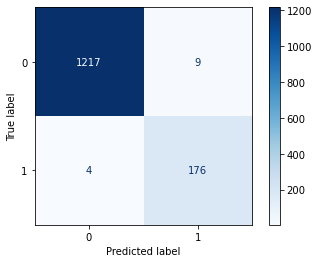

In [187]:
plot_confusion_matrix(RF_model_tr_un_f1, X_test, y_predicted7,
                                 #display_labels=classnames,
                                 cmap=plt.cm.Blues)

In [188]:
import copy
from sklearn.metrics import f1_score 
y_pred_RF=copy.deepcopy(y_predicted7)

y_int=copy.deepcopy(test_labels)

# reclassify the string label names as numeric values
labels = ['no', 'yes']

for i, label in enumerate(labels):
    y_int[y_int == label] = i
    y_pred_RF[y_pred_RF == label] = i
y_int= y_int.astype(int)
y_pred_RF= y_pred_RF.astype(int)

f1_score(y_int, y_pred_RF)  

f1.append(f1_score(y_int, y_pred_RF))

In [189]:
RF_model_tr_un_f1.best_estimator_.named_steps['randomforestclassifier'].feature_importances_

array([0.04225916, 0.0364637 , 0.13486786, 0.05091906, 0.03393594,
       0.03217437, 0.10911502, 0.18121192, 0.12486487, 0.05593723,
       0.042782  , 0.15546888])

In [190]:
feature_list =  ['TCB','TCG','TCW','NDWI','MNDWI','EVI','NDVI','SAVI','MSAVI','MSI','NDMI','SWIR']
# Get numerical feature importances
importances = list(RF_model_tr_un_f1.best_estimator_.named_steps['randomforestclassifier'].feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: SAVI                 Importance: 0.18
Variable: SWIR                 Importance: 0.16
Variable: TCW                  Importance: 0.13
Variable: MSAVI                Importance: 0.12
Variable: NDVI                 Importance: 0.11
Variable: MSI                  Importance: 0.06
Variable: NDWI                 Importance: 0.05
Variable: TCB                  Importance: 0.04
Variable: TCG                  Importance: 0.04
Variable: NDMI                 Importance: 0.04
Variable: MNDWI                Importance: 0.03
Variable: EVI                  Importance: 0.03


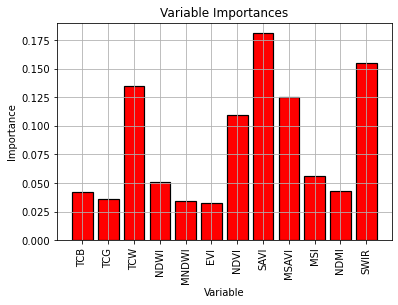

In [191]:
# Reset style 
#plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(importances)))

# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical', color="r",  edgecolor='k', linewidth = 1.2)

# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')

# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');
plt.grid()

In [192]:
from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(test_labels, y_predicted7).ravel()

false_positive_rate = fp / (fp + tn)
print("The false_positive_rate is:",false_positive_rate)

false_negative_rate = fn / (tp + fn)
print("The false_negative_rate is:",false_negative_rate)

true_negative_rate = tn / (tn + fp)
print("The true_negative_rate is:",true_negative_rate)

negative_predictive_value = tn/ (tn + fn)
print("The negative_predictive_value is:",negative_predictive_value)

false_discovery_rate = fp/ (tp + fp)
print("The false_discovery_rate is:",false_discovery_rate)

true_positive_rate = tp / (tp + fn)
print("The true_positive_rate is:",true_positive_rate)
# or simply
#recall_score(y_true, y_pred_class)

positive_predictive_value = tp/ (tp + fp)
print("The positive_predictive_value is:",positive_predictive_value)

The false_positive_rate is: 0.004918032786885246
The false_negative_rate is: 0.06451612903225806
The true_negative_rate is: 0.9950819672131147
The negative_predictive_value is: 0.9902120717781403
The false_discovery_rate is: 0.03333333333333333
The true_positive_rate is: 0.9354838709677419
The positive_predictive_value is: 0.9666666666666667


## Tunning based on the accuracy

**Tunning RF model based on the accuracy**

In [210]:
param_grid = {
    'randomforestclassifier__n_estimators': [int(x) for x in np.linspace(1, 301, 300)],
#     'bootstrap': [True],
#     'max_depth': [100, None],
#     'max_features': [3],
#     'min_samples_leaf': [ 3],
#     'min_samples_split': [2],
}
clf = make_pipeline(
    QuantileTransformer(n_quantiles=50, output_distribution='uniform'), RandomForestClassifier())
# Create the grid search model and fit to the training data
tree_grid_search_all = GridSearchCV(estimator =clf, param_grid=param_grid,return_train_score=True,refit=True, verbose = 1, n_jobs=-1, cv = 15,
                                scoring = 'accuracy')
tree_grid_search_all.fit(X_train, train_labels);

Fitting 15 folds for each of 300 candidates, totalling 4500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 560 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 930 tasks      | elapsed:   25.0s
[Parallel(n_jobs=-1)]: Done 1280 tasks      | elapsed:   44.1s
[Parallel(n_jobs=-1)]: Done 1730 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 2280 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 2930 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 3680 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 4500 out of 4500 | elapsed:  8.8min finished


In [211]:
# evaluate
# tree_grid_search_all, score, score_std = evaluate_model(tree_grid_search_all, cv)

In [212]:
train_scores_all=tree_grid_search_all.cv_results_['mean_train_score']
#train_scores
test_scores_all=tree_grid_search_all.cv_results_['mean_test_score']
#test_scores

In [213]:
#test_scores_all

In [214]:
import operator
enumerate_object = enumerate(test_scores_all)
sorted_pairs = sorted(enumerate_object, key=operator.itemgetter(1))

sorted_indices = []
for index, element in sorted_pairs:
    sorted_indices.append(index)
print(sorted_indices)

[0, 1, 8, 2, 3, 10, 7, 26, 5, 4, 9, 18, 13, 11, 55, 28, 53, 6, 44, 82, 30, 73, 151, 210, 120, 187, 202, 40, 46, 58, 60, 76, 77, 81, 85, 124, 149, 156, 237, 260, 278, 281, 52, 64, 34, 61, 90, 37, 93, 94, 98, 112, 121, 125, 136, 137, 142, 147, 150, 165, 173, 177, 191, 192, 197, 199, 205, 206, 207, 240, 244, 246, 253, 255, 261, 262, 267, 270, 272, 275, 284, 285, 286, 299, 15, 23, 31, 71, 79, 83, 99, 103, 104, 131, 139, 144, 153, 161, 178, 198, 212, 227, 229, 252, 268, 269, 282, 287, 78, 102, 145, 155, 163, 180, 182, 203, 216, 230, 238, 242, 288, 290, 291, 17, 21, 35, 36, 42, 45, 67, 72, 87, 91, 92, 97, 101, 109, 113, 114, 116, 118, 128, 132, 140, 141, 148, 152, 154, 158, 159, 164, 168, 169, 172, 185, 186, 188, 189, 193, 194, 195, 196, 201, 204, 209, 213, 219, 220, 221, 223, 224, 226, 231, 232, 234, 235, 236, 239, 243, 245, 247, 250, 251, 259, 264, 265, 266, 280, 289, 293, 295, 297, 14, 20, 24, 38, 41, 68, 69, 117, 179, 16, 56, 27, 65, 86, 123, 133, 135, 138, 162, 171, 215, 225, 248, 254, 

In [ ]:
# import numpy
# maxElement = numpy.amax(test_scores_all)
# print('Max element from Numpy Array : ', maxElement)
# result = numpy.where(test_scores_all == numpy.amax(test_scores_all))
# print('Returned tuple of arrays :', result)
# print('List of Indices of maximum element :', result[0])

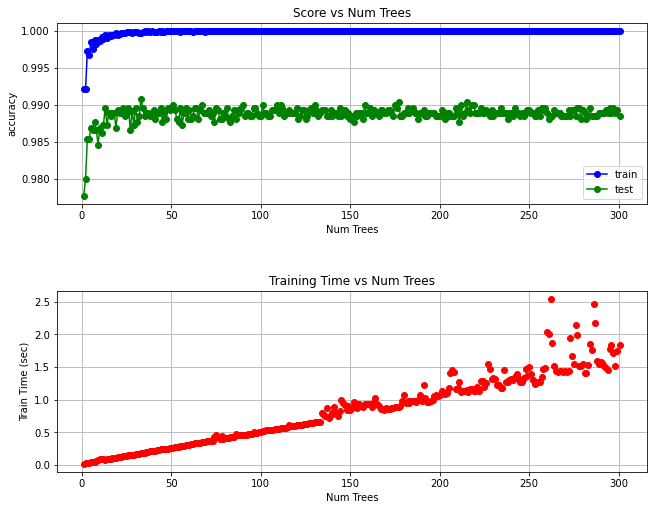

In [215]:
def plot_results(model, param = 'randomforestclassifier__n_estimators', name = 'Num Trees'):
    param_name = 'param_%s' % param

    # Extract information from the cross validation model
    train_scores = model.cv_results_['mean_train_score']
    test_scores = model.cv_results_['mean_test_score']
    train_time = model.cv_results_['mean_fit_time']
    param_values = list(model.cv_results_[param_name])
    
    # Plot the scores over the parameter
    plt.subplots(2, 1, figsize=(10, 8))
    plt.subplot(211)
    plt.plot(param_values, train_scores, 'bo-', label = 'train')
    plt.plot(param_values, test_scores, 'go-', label = 'test')
    #plt.ylim(ymin = -10, ymax = 0)
    plt.legend()
    plt.xlabel(name)
    plt.ylabel('accuracy')
    plt.title('Score vs %s' % name)
    
    plt.grid()
    plt.tight_layout(pad = 4)

    plt.subplot(212)
    plt.plot(param_values, train_time, 'ro')
    #plt.ylim(ymin = 0.0, ymax = 2.0)
    plt.xlabel(name)
    plt.ylabel('Train Time (sec)')
    plt.title('Training Time vs %s' % name)

    plt.grid()
    plt.tight_layout(pad = 4)
    

plot_results(tree_grid_search_all)


In [216]:
%%time
clf_c = make_pipeline(
    QuantileTransformer(n_quantiles=50, output_distribution='uniform'), RandomForestClassifier())
param_grid={'randomforestclassifier__criterion':['entropy'],
           'randomforestclassifier__n_estimators': [ 110, 157, 211, 217, 89, 129, 174, 218, 50, 176, 214, 32]}
RF_model_tr_un_acc = GridSearchCV(estimator=clf_c, param_grid=param_grid, cv=15,verbose=1, refit=True,return_train_score=True)   

# evaluate
cv = StratifiedShuffleSplit(n_splits=15)
RF_model_tr_un_acc, score, score_std = evaluate_model(RF_model_tr_un_acc, cv)


# keep track of results


names.append('RF_model_tr_un_acc')
clfs.append(RF_model_tr_un_acc)
scores.append(score)
scores_std.append(score_std)

Fitting 15 folds for each of 12 candidates, totalling 180 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:  1.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 15 folds for each of 12 candidates, totalling 180 fits


[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:  1.5min finished


Fitting 15 folds for each of 12 candidates, totalling 180 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:  1.6min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 15 folds for each of 12 candidates, totalling 180 fits


[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:  1.6min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 15 folds for each of 12 candidates, totalling 180 fits


[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:  1.6min finished


Fitting 15 folds for each of 12 candidates, totalling 180 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:  1.6min finished


Fitting 15 folds for each of 12 candidates, totalling 180 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:  1.4min finished


Fitting 15 folds for each of 12 candidates, totalling 180 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:  1.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 15 folds for each of 12 candidates, totalling 180 fits


[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:  1.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 15 folds for each of 12 candidates, totalling 180 fits


[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:  1.4min finished


Fitting 15 folds for each of 12 candidates, totalling 180 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:  1.4min finished


Fitting 15 folds for each of 12 candidates, totalling 180 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:  1.4min finished


Fitting 15 folds for each of 12 candidates, totalling 180 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:  1.4min finished


Fitting 15 folds for each of 12 candidates, totalling 180 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:  1.4min finished


Fitting 15 folds for each of 12 candidates, totalling 180 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:  1.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 15 folds for each of 12 candidates, totalling 180 fits


[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:  1.4min finished


Accuracy : 0.9893 (+/- 0.0140)
CPU times: user 23min 15s, sys: 9.38 s, total: 23min 25s
Wall time: 23min 34s


In [217]:
RF_model_tr_un_acc.best_estimator_

Pipeline(steps=[('quantiletransformer', QuantileTransformer(n_quantiles=50)),
                ('randomforestclassifier',
                 RandomForestClassifier(criterion='entropy', n_estimators=50))])

In [218]:
RF_model_tr_un_acc.score(X_test,test_labels)

0.9928876244665719

In [219]:
# save results
cv_results = pd.DataFrame(RF_model_tr_un_acc.cv_results_)      
#cv_results

In [220]:
y_predicted9= cross_val_predict(RF_model_tr_un_acc, X_test, test_labels)

Fitting 15 folds for each of 12 candidates, totalling 180 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:   57.0s finished


Fitting 15 folds for each of 12 candidates, totalling 180 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:   54.5s finished


Fitting 15 folds for each of 12 candidates, totalling 180 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:   55.8s finished


Fitting 15 folds for each of 12 candidates, totalling 180 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:   56.1s finished


Fitting 15 folds for each of 12 candidates, totalling 180 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:   55.9s finished


In [288]:
from sklearn import metrics
print(metrics.classification_report(test_labels, y_predicted9, digits=4))

              precision    recall  f1-score   support

           0     0.9894    0.9951    0.9922      1220
           1     0.9665    0.9301    0.9479       186

    accuracy                         0.9865      1406
   macro avg     0.9779    0.9626    0.9701      1406
weighted avg     0.9864    0.9865    0.9864      1406



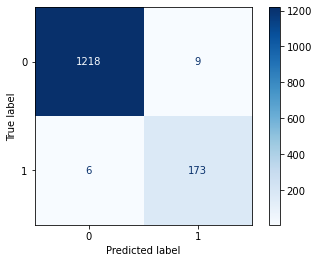

In [222]:
plot_confusion_matrix(RF_model_tr_un_acc, X_test, y_predicted9,
                                 #display_labels=classnames,
                                 cmap=plt.cm.Blues)

In [223]:
import copy
from sklearn.metrics import f1_score 
y_pred_RF=copy.deepcopy(y_predicted9)

y_int=copy.deepcopy(test_labels)

# reclassify the string label names as numeric values
labels = ['no', 'yes']

for i, label in enumerate(labels):
    y_int[y_int == label] = i
    y_pred_RF[y_pred_RF == label] = i
y_int= y_int.astype(int)
y_pred_RF= y_pred_RF.astype(int)

f1_score(y_int, y_pred_RF)  

f1.append(f1_score(y_int, y_pred_RF))

In [224]:
RF_model_tr_un_acc.best_estimator_.named_steps['randomforestclassifier'].feature_importances_

array([0.04591692, 0.03378778, 0.13361605, 0.05441775, 0.02411133,
       0.03371512, 0.08353195, 0.21277787, 0.11730383, 0.04554531,
       0.03359523, 0.18168085])

In [225]:
# import pandas as pd
# feature_imp = pd.Series(RF_model_tr_un.best_estimator_.named_steps['randomforestclassifier'].feature_importances_).sort_values(ascending=False)
# #feature_imp

# features=pd.Series(RF_model_tr_un.best_estimator_.named_steps['randomforestclassifier'].feature_importances_)
# #features

# band_list1 =  ['TCB','TCG','TCW','NDWI','MNDWI','EVI','NDVI','SAVI','MSAVI','MSI','NDMI','SWIR','Slope']
# plt.figure(figsize=(12, 8))
# plt.plot(band_list1, features,"-o")
# plt.grid()

In [226]:
feature_list =  ['TCB','TCG','TCW','NDWI','MNDWI','EVI','NDVI','SAVI','MSAVI','MSI','NDMI','SWIR']
# Get numerical feature importances
importances = list(RF_model_tr_un_acc.best_estimator_.named_steps['randomforestclassifier'].feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: SAVI                 Importance: 0.21
Variable: SWIR                 Importance: 0.18
Variable: TCW                  Importance: 0.13
Variable: MSAVI                Importance: 0.12
Variable: NDVI                 Importance: 0.08
Variable: TCB                  Importance: 0.05
Variable: NDWI                 Importance: 0.05
Variable: MSI                  Importance: 0.05
Variable: TCG                  Importance: 0.03
Variable: EVI                  Importance: 0.03
Variable: NDMI                 Importance: 0.03
Variable: MNDWI                Importance: 0.02


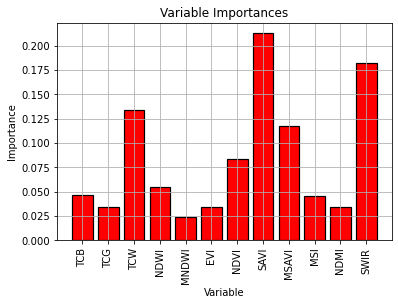

In [227]:
# Reset style 
#plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(importances)))

# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical', color = 'r', edgecolor = 'k', linewidth = 1.2)

# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')

# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');
plt.grid()

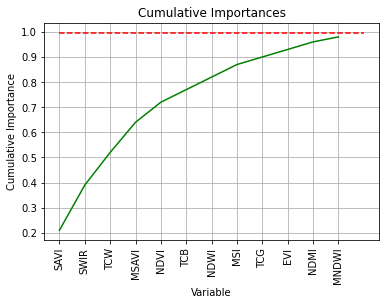

In [228]:
# List of features sorted from most to least important
sorted_importances = [importance[1] for importance in feature_importances]
sorted_features = [importance[0] for importance in feature_importances]

# Cumulative importances
cumulative_importances = np.cumsum(sorted_importances)

# Make a line graph
plt.plot(x_values, cumulative_importances, 'g-')

# Draw line at 95% of importance retained
plt.hlines(y = 0.997, xmin=0, xmax=len(sorted_importances), color = 'r', linestyles = 'dashed')

# Format x ticks and labels
plt.xticks(x_values, sorted_features, rotation = 'vertical')

# Axis labels and title
plt.xlabel('Variable'); plt.ylabel('Cumulative Importance'); plt.title('Cumulative Importances');
plt.grid()

In [229]:
from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(test_labels, y_predicted9).ravel()

false_positive_rate = fp / (fp + tn)
print("The false_positive_rate is:",false_positive_rate)

false_negative_rate = fn / (tp + fn)
print("The false_negative_rate is:",false_negative_rate)

true_negative_rate = tn / (tn + fp)
print("The true_negative_rate is:",true_negative_rate)

negative_predictive_value = tn/ (tn + fn)
print("The negative_predictive_value is:",negative_predictive_value)

false_discovery_rate = fp/ (tp + fp)
print("The false_discovery_rate is:",false_discovery_rate)

true_positive_rate = tp / (tp + fn)
print("The true_positive_rate is:",true_positive_rate)
# or simply
#recall_score(y_true, y_pred_class)

positive_predictive_value = tp/ (tp + fp)
print("The positive_predictive_value is:",positive_predictive_value)

The false_positive_rate is: 0.004918032786885246
The false_negative_rate is: 0.06989247311827956
The true_negative_rate is: 0.9950819672131147
The negative_predictive_value is: 0.9894050529747351
The false_discovery_rate is: 0.0335195530726257
The true_positive_rate is: 0.9301075268817204
The positive_predictive_value is: 0.9664804469273743


In [230]:
y_score_1 = RF_model_tr_un.predict_proba(X_test)[:, 1]
y_score_1.shape

y_score_0 = RF_model_tr_un.predict_proba(X_test)[:, 0]
y_score_0.shape

(1406,)

In [231]:
y_score_0_1=RF_model_tr_un.predict_proba(X)

# For each scene: using the model with the highest metric, predict the RTSs on the entire scene.


**Metric = Accuracy**

In [285]:
res = pd.DataFrame(index=names, data={'clf': clfs, 'score': scores, 'score_std': scores_std})
res.sort_values('score')

,clf,score,score_std
knn_model_tr_uni_acc,"GridSearchCV(cv=10,\n estimator=Pi...",0.987739,0.009873
knn_model_tr_un_f1,"GridSearchCV(cv=15,\n estimator=Pi...",0.987739,0.008012
RF_model_tr_nor_f1,"GridSearchCV(cv=15,\n estimator=Pi...",0.987995,0.012154
RF_100_trees_uni,"GridSearchCV(cv=15,\n estimator=Pi...",0.988497,0.011906
RF_100_trees_normal,"GridSearchCV(cv=15,\n estimator=Pi...",0.988497,0.011906
KNN_QT_uniform,"GridSearchCV(cv=15,\n estimator=Pi...",0.988497,0.010321
RF_model_tr_nor_acc,"GridSearchCV(cv=15,\n estimator=Pi...",0.988506,0.011537
KNN_QT_normal,"GridSearchCV(cv=15,\n estimator=Pi...",0.988882,0.011483
knn_model_tr_norm_acc,"GridSearchCV(cv=10,\n estimator=Pi...",0.988889,0.010535
RF_model_tr_un_f1,"GridSearchCV(cv=15,\n estimator=Pi...",0.989017,0.011146


**Metric = f1 score**

In [286]:
res1 = pd.DataFrame(index=names, data={'clf': clfs, 'score': scores, 'score_std': scores_std,'f1':f1})
res1.sort_values('f1')

,clf,score,score_std,f1
KNN_QT_normal,"GridSearchCV(cv=15,\n estimator=Pi...",0.988882,0.011483,0.932615
RF_model_tr_nor_f1,"GridSearchCV(cv=15,\n estimator=Pi...",0.987995,0.012154,0.933702
knn_model_tr_nor,"GridSearchCV(cv=10,\n estimator=Pi...",0.991315,0.010642,0.940541
knn_model_tr_norm_acc,"GridSearchCV(cv=10,\n estimator=Pi...",0.988889,0.010535,0.940541
RF_100_trees_uni,"GridSearchCV(cv=15,\n estimator=Pi...",0.988497,0.011906,0.945652
KNN_QT_uniform,"GridSearchCV(cv=15,\n estimator=Pi...",0.988497,0.010321,0.945946
RF_100_trees_normal,"GridSearchCV(cv=15,\n estimator=Pi...",0.988497,0.011906,0.947945
RF_model_tr_un_acc,"GridSearchCV(cv=15,\n estimator=Pi...",0.989272,0.014046,0.947945
RF_model_tr_nor_acc,"GridSearchCV(cv=15,\n estimator=Pi...",0.988506,0.011537,0.947945
RF_model_tr_un_f1,"GridSearchCV(cv=15,\n estimator=Pi...",0.989017,0.011146,0.950820


In [ ]:
# save the model with the highest accuracy

bands = '12'
res.to_pickle('model_results_'+bands+'_bands.pkl'.format(bands))
res_saved = pd.read_pickle('model_results_12_bands.pkl')

In [ ]:
# save the model with the highest f1 score

bands = '12'
res1.to_pickle('model_results1_'+bands+'_bands.pkl'.format(bands))
res_model1 = pd.read_pickle('model_results1_12_bands.pkl')

In [62]:
import numpy as np
import pandas as pd
res_saved = pd.read_pickle('model_results_12_bands.pkl')

In [63]:
# which model do we want to check? select by score!
clf = res_saved.loc[res_saved['score'] == res_saved['score'].max(), 'clf'].values[0]
# classifier name
classifier_name = res_saved.loc[res_saved['score'] == res_saved['score'].max(), 'clf'].index.values[0]             # knn

In [64]:
classifier_name

'KNN_QT_uniform'

In [6]:
# clf1 = res1.loc[res1['f1'] == res1['f1'].max(), 'clf'].values[0]
# # classifier name
# classifier_name1 = res1.loc[res1['f1'] == res1['f1'].max(), 'clf'].index.values[0]       
# classifier_name1

In [281]:
X_pred=np.nan_to_num(X_pred)

In [72]:
X_pred2=np.nan_to_num(X_pred2)

In [73]:
X_pred3=np.nan_to_num(X_pred3)

In [74]:
X_pred4=np.nan_to_num(X_pred4)

In [297]:
# original shape of scene
orig_shape = (height, width)

# run prediction on the image
y_pred = clf.predict(X_pred)

# # reshape y back to a 2D matrix for visualization
# y_pred_img = y_pred.reshape(orig_shape)

In [75]:
orig_shape_2 = (height2, width2)
# run prediction on the image
y_pred2 = clf.predict(X_pred2)

In [76]:
orig_shape_3 = (height3, width3)
# run prediction on the image
y_pred3 = clf.predict(X_pred3)

In [82]:
orig_shape_4 = (height4, width4)
# run prediction on the imageq23
y_pred4 = clf.predict(X_pred4)

In [ ]:
y_pred_img = y_pred.reshape(orig_shape)

In [78]:
y_pred_img2 = y_pred2.reshape(orig_shape_2)

In [79]:
y_pred_img3 = y_pred3.reshape(orig_shape_3)

In [83]:
y_pred_img4 = y_pred4.reshape(orig_shape_4)

In [ ]:
(clf.predict(X) == y).sum()

In [ ]:
# #reclassify the string label names as numeric values
# labels = ['yes', 'no']

# for i, label in enumerate(labels):
#     y_pred_img[y_pred_img == label] = i
# y_pred_img= y_pred_img.astype(int)


# Image-prediction

In [ ]:
from matplotlib import colors

fig, ax = plt.subplots(figsize=(20,15),dpi= 100)


cmap = colors.ListedColormap(['red','green'])

predict_plot = ax.imshow(y_pred_img, cmap=cmap)
cbar = fig.colorbar(predict_plot, label='class')
cbar.set_ticks(np.arange(0, len(labels)))
cbar.set_ticklabels(labels)
#ax.set_title(classifier_name)
ax.set_axis_off()

In [ ]:
from matplotlib import colors

fig, ax = plt.subplots(figsize=(20,15),dpi= 100)


cmap = colors.ListedColormap(['red','green'])

predict_plot2 = ax.imshow(y_pred_img2, cmap=cmap)
cbar = fig.colorbar(predict_plot2, label='class')
cbar.set_ticks(np.arange(0, len(labels)))
cbar.set_ticklabels(labels)
#ax.set_title(classifier_name)
ax.set_axis_off()

In [ ]:
from matplotlib import colors

fig, ax = plt.subplots(figsize=(20,15),dpi= 100)


cmap = colors.ListedColormap(['red','green'])

predict_plot3 = ax.imshow(y_pred_img3, cmap=cmap)
cbar = fig.colorbar(predict_plot3, label='class')
cbar.set_ticks(np.arange(0, len(labels)))
cbar.set_ticklabels(labels)
#ax.set_title(classifier_name)
ax.set_axis_off()

In [ ]:
from matplotlib import colors

fig, ax = plt.subplots(figsize=(20,15),dpi= 100)


cmap = colors.ListedColormap(['red','green'])

predict_plot4 = ax.imshow(y_pred_img4, cmap=cmap)
cbar = fig.colorbar(predict_plot4, label='class')
cbar.set_ticks(np.arange(0, len(labels)))
cbar.set_ticklabels(labels)
#ax.set_title(classifier_name)
ax.set_axis_off()

In [ ]:
# Write an array as a raster band to a new 8-bit file. For
# the new file's profile, we start with the profile of the source
profile = full_dataset.profile

# And then change the band count to 1, set the and set the dtype to uint8
profile.update(dtype=rasterio.float32, count=1)

# for each label write as separate binary array to a new directory
tif_out_dir = 'results_12_Bands_corrected/'
try: 
    os.mkdir(tif_out_dir)
except:
    pass
for i, label in enumerate(labels):
    array_out = y_pred_img.copy()
    array_out[array_out != i] = 1
    array_out[array_out == i] = 0
    tif_out = '{}{}12_Bands_E_RF_uni.tif'.format(tif_out_dir, label, classifier_name)
    with rasterio.open(tif_out, 'w', **profile) as dst:
        dst.write(array_out.astype(rasterio.float32), 1)

In [80]:
# Write an array as a raster band to a new 8-bit file. For
# the new file's profile, we start with the profile of the source
profile = full_dataset2.profile

# And then change the band count to 1, set the and set the dtype to uint8
profile.update(dtype=rasterio.float32, count=1)

# for each label write as separate binary array to a new directory
tif_out_dir = 'results_12_Bands_corrected/'
try: 
    os.mkdir(tif_out_dir)
except:
    pass
for i, label in enumerate(labels):
    array_out = y_pred_img2.copy()
    array_out[array_out != i] = 1
    array_out[array_out == i] = 0
    tif_out = '{}{}12_B_South_KNN_norm_acc.tif'.format(tif_out_dir, label, classifier_name)
    with rasterio.open(tif_out, 'w', **profile) as dst:
        dst.write(array_out.astype(rasterio.float32), 1)

In [81]:
# Write an array as a raster band to a new 8-bit file. For
# the new file's profile, we start with the profile of the source
profile = full_dataset3.profile

# And then change the band count to 1, set the and set the dtype to uint8
profile.update(dtype=rasterio.float32, count=1)

# for each label write as separate binary array to a new directory
tif_out_dir = 'results_12_Bands_corrected/'
try: 
    os.mkdir(tif_out_dir)
except:
    pass
for i, label in enumerate(labels):
    array_out = y_pred_img3.copy()
    array_out[array_out != i] = 1
    array_out[array_out == i] = 0
    tif_out = '{}{}12_B_central_KNN_norm_acc.tif'.format(tif_out_dir, label, classifier_name)
    with rasterio.open(tif_out, 'w', **profile) as dst:
        dst.write(array_out.astype(rasterio.float32), 1)

In [84]:
# Write an array as a raster band to a new 8-bit file. For
# the new file's profile, we start with the profile of the source
profile = full_dataset4.profile

# And then change the band count to 1, set the and set the dtype to uint8
profile.update(dtype=rasterio.float32, count=1)

# for each label write as separate binary array to a new directory
tif_out_dir = 'results_12_Bands_corrected/'
try: 
    os.mkdir(tif_out_dir)
except:
    pass
for i, label in enumerate(labels):
    array_out = y_pred_img4.copy()
    array_out[array_out != i] = 1
    array_out[array_out == i] = 0
    tif_out = '{}{}12_B_north_KNN_norm_acc.tif.tif'.format(tif_out_dir, label, classifier_name)
    with rasterio.open(tif_out, 'w', **profile) as dst:
        dst.write(array_out.astype(rasterio.float32), 1)